In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.api import OLS
import yfinance as yf
from datetime import timedelta

In [2]:
data = yf.Tickers("EWA EWC GLD USO TSLA NFLX AMZN ^GSPC")
history = data.history(start='2016-05-24', end='2020-06-01')#, end='2012-04-09')
pairs = 0.5*(history['Open'] + history['Close'])[['TSLA', 'AMZN']]
xname, yname = pairs.columns

sp500 = history['Close']['^GSPC']

[*********************100%***********************]  8 of 8 completed


In [3]:
lookback = 20
hedge = np.nan * np.zeros(len(pairs))

for t in range(lookback,len(hedge)):
    Y = pairs[yname][t-lookback:t]
    X = pairs[xname][t-lookback:t]
    model = OLS(Y, np.array([X, np.ones(len(X))]).T )
    hedge[t] = model.fit().params[0]

In [4]:
yport = pairs * np.array([ -hedge, np.ones(len(hedge))]).T
yport = yport.sum(axis=1, skipna=False)

In [5]:
#Vanilla num_units EX3.1 Ernie2
lookback = 20
z_score = (yport - yport.rolling(window=lookback).mean())/yport.rolling(window=lookback).std()
num_units = -z_score.values
positions = pairs * ( np.array([num_units, num_units]).T * np.array([hedge, -np.ones(len(num_units))]).T)
pnl = (positions.shift(-1)*pairs.pct_change()).sum(axis=1)
ret_vanilla = pnl/np.abs(positions).shift(-1).sum(axis=1)

In [6]:
#Bollinger band ernie
entry_z_score = 1
exit_z_score = 0
z_score = (yport - yport.rolling(window=lookback).mean())/yport.rolling(window=lookback).std()
longs_entry = z_score < -entry_z_score
longs_exit = z_score >= -exit_z_score
shorts_entry = z_score > entry_z_score
shorts_exit = z_score <= exit_z_score

num_units_long = np.nan*np.zeros(len(yport))
num_units_short = np.nan*np.zeros(len(yport))

num_units_long[0] = 0
num_units_long[longs_entry] = 1
num_units_long[longs_exit] = 0
num_units_long = pd.DataFrame(num_units_long).fillna(method="ffill").values.T

num_units_short[0] = 0
num_units_short[shorts_entry] = -1
num_units_short[shorts_exit] = 0
num_units_short = pd.DataFrame(num_units_short).fillna(method="ffill").values.T

#Vanilla num_units EX3.1 Ernie2
num_units = (num_units_long + num_units_short).reshape(-1,)
positions = pairs * ( np.array([num_units, num_units]).T * np.array([hedge, -np.ones(len(num_units))]).T)
pnl = (positions.shift(-1)*pairs.pct_change()).sum(axis=1)
ret_bollinger = pnl/np.abs(positions).shift(-1).sum(axis=1)

In [7]:
x = np.array([pairs[xname].values, np.ones(len(pairs[xname].values))])
y = pairs[yname].values
delta = 1e-4
yhat = np.nan*np.zeros(len(pairs))
e = np.nan*np.zeros(len(pairs))
Q = np.nan*np.zeros(len(pairs))

P = np.zeros((2,2))
beta = np.nan*np.zeros((2,x.shape[1]))
Vw = (delta/(1-delta))*np.eye(2)
Ve = 1e-3

beta[:,0] = 0
R = P
for t in range(len(pairs)):
    if t>0:
        beta[:,t] = beta[:,t-1]
        R = P + Vw
    
    yhat[t] = x[:,t]@beta[:,t]
    Q[t]=x[:,t]@R@x[:,t] + Ve
    
    e[t] = y[t] - yhat[t]
    
    K=(R@x[:,t])/Q[t]
    
    beta[:,t] = beta[:,t] + K*e[t]
    
    P = R-K*x[:,t]*R
    
hedge = beta[0,1:]
e = e[1:]
Q = Q[1:]

In [8]:
#Kalman Filter
longs_entry = (e < -np.sqrt(Q)).reshape(-1,)
longs_exit = (e > -np.sqrt(Q)).reshape(-1,)
shorts_entry = (e > np.sqrt(Q)).reshape(-1,)
shorts_exit = (e < np.sqrt(Q)).reshape(-1,)


num_units_long = np.nan*np.zeros(len(e))
num_units_short = np.nan*np.zeros(len(e))

num_units_long[0] = 0
num_units_long[longs_entry] = 1
num_units_long[longs_exit] = 0
num_units_long = pd.DataFrame(num_units_long).fillna(method="ffill").values.T

num_units_short[0] = 0
num_units_short[shorts_entry] = -1
num_units_short[shorts_exit] = 0
num_units_short = pd.DataFrame(num_units_short).fillna(method="ffill").values.T

#Vanilla num_units EX3.1 Ernie2
num_units = (num_units_long + num_units_short).reshape(-1,)
positions = pairs[1:] * ( np.array([num_units, num_units]).T * np.array([hedge, -np.ones(len(num_units))]).T)
pnl = (positions.shift(-1)*pairs[1:].pct_change()).sum(axis=1)
ret_kalman = pnl/np.abs(positions).shift(-1).sum(axis=1)

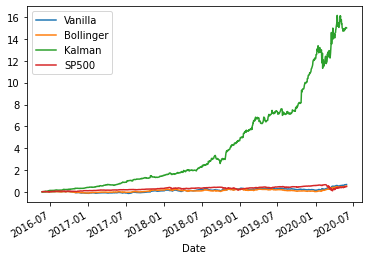

In [9]:
#sp500.pct_change().cumsum().plot()
((ret_vanilla.fillna(0) + 1).cumprod()  -1).plot()
((ret_bollinger.fillna(0) + 1).cumprod()  -1).plot()
((ret_kalman.fillna(0) + 1).cumprod()  - 1).plot()
((sp500.pct_change().fillna(0) + 1).cumprod()  - 1).plot()
plt.legend(['Vanilla', 'Bollinger', 'Kalman', 'SP500'])

In [ ]:
#Next Make portfolio of multiple pairs to trade
#Try Pairs trade with 3 pairs